# SEL634 - Laboratório de Robôs Manipuladores

## Inicialização da biblioteca

Carregar a biblioteca de robótica para Python:

In [ ]:
# !python3 -m pip install --user --upgrade pip==20.1
!pip install roboticstoolbox-python
!pip install spatialmath-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
#import roboticstoolbox as rtb
from roboticstoolbox import *
from spatialmath import *
from math import pi
import matplotlib.pyplot as plt
from matplotlib import cm
np.set_printoptions(linewidth=100, formatter={'float': lambda x: f"{x:8.4g}" if abs(x) > 1e-10 else f"{0:8.4g}"})

# no Binder utilizar essa linha
# %matplotlib notebook  
# no Colab utilizar essa linha
%matplotlib inline

In [ ]:
# parametros globais de plot
plt.rc('legend',fontsize='large')
plt.rc('lines', linewidth=2)
plt.rcParams.update({'axes.facecolor':'white'})

## Cinemática Direta do Robô Kinova Gen3

O robô Kinova Gen3 pode ser modelado pela seguinte função (ver Tarefa 2):

In [ ]:
def kinova_robot(my_name):
  robot = DHRobot(
      [
       # Colocar seu código aqui para completar a descrição do robô
        RevoluteDH(d=-(0.1564+0.1284), alpha=pi/2),
            RevoluteDH(d=-(0.0054+0.0064), alpha=pi/2, offset=pi),
            RevoluteDH(d=-(0.2104+0.2104), alpha=pi/2, offset=pi),
            RevoluteDH(d=-(0.0064+0.0064), alpha=pi/2, offset=pi),
            RevoluteDH(d=-(0.2084+0.1059), alpha=pi/2, offset=pi),
            RevoluteDH(alpha=pi/2, offset=pi),
            RevoluteDH(d=-(0.1059+0.0615), alpha=pi, offset=pi)
       ], name=my_name)
  H_B0 = SE3.Rz(0)*SE3(0,0,0)*SE3(0,0,0)*SE3.Rx(pi)
  robot.base = H_B0
  return robot


A pose do efetuador do robô Kinova Gen3 é dada em relação a base, $B$, pela função:

In [ ]:
def pose_efetuador(robot, q):
  H_B7 = robot.fkine(q)
  return H_B7

## Trajetória do Robô no Espaço das Juntas

Considere que a junta $i$ possui a seguinte trajetória  em graus no tempo que leva a junta $i$ da posição $\theta_{si}$ até $\theta_{gi}$ em um dado tempo $T_d$:
$$ \theta_i (t) = c_{0i} + c_{1i} t + c_{2i} t^2 + c_{3i} t^3 + c_{4i} t^4 + c_{5i} t^5 $$
Para velocidades e acelerações iniciais e finais iguais a zero, os coeficientes do polinômio são dados em função da posição inicial e final e do intervalo de tempo:
\begin{eqnarray*}
	&c_{0i}& = \theta_{si}\\
	&c_{1i}& = c_{2i} = 0\\
	&c_{3i}& = \frac{10(\theta_{gi}-\theta_{si})}{T_d^{3}}\\
	&c_{4i}& = \frac{15(\theta_{si}-\theta_{gi})}{T_d^{4}}\\
	&c_{5i}& = \frac{6(\theta_{gi}-\theta_{si})}{T_d^{5}}
\end{eqnarray*}

A velocidade de cada junta para condições iniciais nulas é dada por:
$$ \dot\theta_i (t) = c_{1i} + 2c_{2i} t + 3c_{3i} t^2 + 4c_{4i} t^3 + 5c_{5i} t^4 $$

A aceleração de cada junta para condições iniciais nulas é dada por:
$$ \ddot\theta_i (t) = 2c_{2i} + 6c_{3i} t + 12c_{4i} t^2 + 20c_{5i} t^3 $$

A função a seguir foi implementada na Tarefa 3 para calcular a trajetória das juntas do manipulador:


In [ ]:
def calcular_trajetoria(theta_s, theta_g, Td, dt):
  # Coloque seu codigo aqui
  N = len(theta_s) # numero de juntas
  
  t = np.arange(0,Td+dt,dt) # tempo
  M = len(t) # qtd de pontos na trajetoria
  t = t.reshape(M,1)

  # constantes: (1,N)
  c0 = theta_s.reshape(1,N)
  c1 = np.zeros( (c0.shape) ).reshape(1,N)
  c2 = np.zeros( (c0.shape) ).reshape(1,N)
  c3 = (10/ Td**3)*(theta_g-theta_s).reshape(1,N)
  c4 = (15/ Td**4)*(theta_s-theta_g).reshape(1,N)
  c5 = (6/ Td**5)*(theta_g-theta_s).reshape(1,N)

  c = np.concatenate( (c0, c1, c2, c3, c4, c5 ) , axis=0)
  # (coef, N) - linhas: num_coeficientes, colunas: cada junta

  potencias = np.concatenate( (np.ones( (M,1) ), t, (t**2), (t**3), (t**4), (t**5) ) , axis=1)
  # (M, coef) - linhas: ptos trajetoria, colunas: num_coeficientes

  ##############################################################################
  # POSICAO
  theta_t = np.dot(potencias,c) # (M, N): (M, coef) x (coef, N)
  

  ##############################################################################
  # VELOCIDADE
  # ajustar coeficientes para velocidade:
  c_veloc = np.concatenate( (c1, (2*c2), (3*c3), (4*c4), (5*c5) ) , axis=0)
  # (coef, N) - linhas: coeficientes, colunas: cada junta
  
  potencias_veloc = potencias[:, 0:5] # de t^0 a t^4
  
  dtheta_t = np.dot(potencias_veloc,c_veloc) # (M, N): (M, coef) x (coef, N)


  ##############################################################################
  # ACELERACAO
  # ajustar coeficientes para aceleracao:
  c_acc = np.concatenate( ((2*c2), (6*c3), (12*c4), (20*c5) ) , axis=0)
  # (coef, N) - linhas: coeficientes, colunas: cada junta
  
  potencias_acc = potencias[:, 0:4] # de t^0 a t^3
  
  ddtheta_t = np.dot(potencias_acc,c_acc) # (M, N): (M, coef) x (coef, N)

  ##############################################################################

  return theta_t, dtheta_t, ddtheta_t

A função a seguir foi implementada na Tarefa 3 para calcular a sequencia no tempo de matrizes de transformação homogênea que representa a pose do robô (posição e orientação do efetuador)

In [ ]:
def calcular_traj_efetuador(robot, theta_t):
  # Coloque seu codigo aqui
  H_efetuador = pose_efetuador(robot,theta_t) # objeto proprio da biblioteca (saida do kfine)
  H_efetuador = np.array(H_efetuador.A) # matriz homegenea em np.array: usar ".A"

  return H_efetuador

## Velocidade do Efetuador do Robô Manipulador

Na tarefa 4 você implementou as seguintes funções para calcular o Jacobiano do manipulador: 


In [ ]:
def calcular_jacobiano(robot,theta):
  # Coloque seu codigo aqui
    # SLIDE 10
    # SLIDE 11

  n_juntas = len(robot.revolutejoints)

  J_efetuador = np.empty( (theta.shape[0], 6, n_juntas) )

  for q in range(theta.shape[0]):
    On = np.array( robot.A(n_juntas-1, theta[q,:]) ) # H0_n
    On = On[0:3, 3]                                  # O0_n

    for junta in range(n_juntas):
  # ================================================================================
      if junta == 0:
        Z = np.array( [0,0,1] )
        O = np.array( [0,0,0] )

      if junta > 0:
        H = np.array( robot.A(junta-1, theta[q,:]) ) # H0_{i-1}
        Z = H[0:3, 2]
        O = H[0:3, 3]

  # ================================================================================

      # JUNTA DE REVOLUCAO
      if robot.revolutejoints[junta] == True:
        # velocidade linear
        # J_v                      =                 z_{i-1} X (On - O_{i-1})
        J_efetuador[q, 0:3, junta] = np.array(np.cross( Z.tolist(), (On - O).tolist() ))
        
        # velocidade angular
        # J_w                     =    z_{i-1}
        J_efetuador[q, 3:, junta] = np.array(Z)



      # JUNTA PRISMATICA
      else:
        # velocidade linear
        # J_v                      =  z_{i-1}
        J_efetuador[q, 0:3, junta] = np.array(Z)
        
        # velocidade angular
        # J_w                     =    [0,0,0].T
        J_efetuador[q, 3:, junta] = np.array( [0,0,0] ).reshape(3,1)


  return J_efetuador

Na tarefa 4, você implementou uma função que calcula a velocidade do efetuador do manipulador Kinova Gen3 em relação a sua base $B$.

O calculo das velocidades linear e angular do manipulador em relação ao sistema $\{0\}$ para um dado instante de tempo é:

$$\begin{bmatrix} ^0v_n(t) \\ ^0w_n(t) \end{bmatrix} = {^0J_n}(q(t)) ~\dot q(t) $$

Como a origem do sistema de coordenadas $\{0\}$ e $\{B\}$ coincidem, para transformar o vetor de velocidades para o sistema de coordenadas da base $\{B\}$:

$$ \begin{bmatrix} ^Bv_n(t) \\ ^Bw_n(t) \end{bmatrix} = {^BR_0}\begin{bmatrix} ^0v_n(t) \\ ^0w_n(t) \end{bmatrix} $$



In [ ]:
def calcular_vel_efetuador(robot,theta_t,dtheta_t):
  # Coloque seu codigo aqui
  
  J_efetuador = calcular_jacobiano(robot,theta_t)
  V_efetuador = np.empty( (theta_t.shape[0], 6, 1) )

  for J in range(J_efetuador.shape[0]):  
    #            v       =          J                  *     q'
    V_efetuador[J, :, :] = np.dot( J_efetuador[J, :, :], dtheta_t[J, :] ).reshape(6,1)

    # transformacao {0} para {B} 
    H_B0 = np.array(SE3.Rz(0)*SE3(0,0,0)*SE3(0,0,0)*SE3.Rx(pi))
    R_B0 = H_B0[0:3, 0:3]

    V_efetuador[J, 0:3, :] = np.dot( R_B0, V_efetuador[J, 0:3, :] ) # linear
    V_efetuador[J, 3:, :]  = np.dot( R_B0, V_efetuador[J, 3:, :] )  # angular


  return V_efetuador

## 5. Controle de Trajetória do Efetuador no Espaço Cartesiano

**Aviso:** Esta é uma versão preliminar do documento que está sujeita a revisão. Estou procurando deixar a descrição desta tarefa mais clara e completa.

Nesta tarefa você irá implementar um conjunto de funções que possibilitam o controle da posição do efetuador no espaço cartesiano. Isso permite que o efetuador possa descrever uma trajetória reta no espaço 3D cartesiano.

### 5.1 Descrição de uma trajetória reta no espaço cartesiano

Considere uma trajetória descrita por um seguimento de reta no espaço cartesiano que tem início no ponto 3D, $\mathbf{^Bx_s} = [x_s, y_s, z_s]^T$, e término no ponto 3D, $\mathbf{^Bx_g} = [x_g, y_g, z_g]^T$, ambos representados no sistema de coordenadas da base $\{B\}$. A velocidade linear do efetuador no inicio e fim da trajetória devem ser iguais a $0$. 

Quando a velocidade inicial e final do ponto é zero, a trajetória do ponto 3D a ser executada pode ser representada por um polinômio de quinta ordem no tempo:

$$ \mathbf{x} (t) = c_{0} + c_{1} t + c_{2} t^2 + c_{3} t^3 + c_{4} t^4 + c_{5} t^5 $$
Para velocidades e acelerações iniciais e finais iguais a zero, os coeficientes do polinômio são dados em função da posição inicial e final e do intervalo de tempo $T_d$:
\begin{eqnarray*}
	&c_{0}& = \mathbf{x_s}\\
	&c_{1}& = c_{2i} = 0\\
	&c_{3}& = \frac{10(\mathbf{x_g}-\mathbf{x_s})}{T_d^{3}}\\
	&c_{4}& = \frac{15(\mathbf{x_s}-\mathbf{x_g})}{T_d^{4}}\\
	&c_{5}& = \frac{6(\mathbf{x_g}-\mathbf{x_s})}{T_d^{5}}
\end{eqnarray*}

Observe que $\mathbf{x_s}$ e $\mathbf{x_g}$ tem dimensão $3 \times 1$, e portanto, os coeficientes $c_0$, $c_1$, $c_2$, $c_3$, $c_4$, $c_5$ também possuem dimensão $3 \times 1$. 

A velocidade linear do efetuador para condições iniciais nulas é dada por:
$$ \mathbf{\dot  x} (t) = c_{1} + 2c_{2} t + 3c_{3} t^2 + 4c_{4} t^3 + 5c_{5} t^4 $$

Importante ressaltar, que a trajetória de quinta ordem no espaço cartesianos não será uma reta quando as velocidades iniciais ou finais foram diferentes de zero.

Para que não seja necessário utilizar a cinemática inversa do robô manipulador, nessa tarefa você irá considerar que a configuração inicial e final do robô foram dadas, ou seja, $\mathbf{q_s}$ e $\mathbf{q_g}$. Então, utilizando a função `pose_efetuador(robot, q)`, você irá obter a posição inicial $\mathbf{x_s}$ e posição final $\mathbf{x_g}$ do efetuador.

Complete o código a seguir para implementar uma função que retorna os pontos $\mathbf{x}(t)$ da trajetória do efetuador e as velocidades lineares do efetuador $\mathbf{\dot x}(t)$.




In [ ]:
def calcular_trajetoria_cartesiano(robot, q_s, q_g, Td, dt):
  # Coloque seu codigo aqui
  N = len(q_s) # numero de juntas
  
  t = np.arange(0,Td+dt,dt) # tempo
  M = len(t) # qtd de pontos na trajetoria
  t = t.reshape(M,1)

  H_s = pose_efetuador(robot, q_s)
  # tirar o deslocamento
  x_s = H_s.A[0:3, 3]

  H_g = pose_efetuador(robot, q_g)
  # tirar o deslocamento
  x_g = H_g.A[0:3, 3]


  # constantes: (1,3)
  c0 = ( x_s ).reshape(1,3)
  c1 = np.zeros( (c0.shape) ).reshape(1,3)
  c2 = np.zeros( (c0.shape) ).reshape(1,3)
  c3 = (10/ Td**3)*(x_g-x_s).reshape(1,3)
  c4 = (15/ Td**4)*(x_s-x_g).reshape(1,3)
  c5 = (6/ Td**5)*(x_g-x_s).reshape(1,3)

  c = np.concatenate( (c0, c1, c2, c3, c4, c5 ) , axis=0)
  # (coef, 3) - linhas: num_coeficientes, colunas: x,y,z

  potencias = np.concatenate( (np.ones( (M,1) ), t, (t**2), (t**3), (t**4), (t**5) ) , axis=1)
  # (M, coef) - linhas: ptos trajetoria, colunas: num_coeficientes

  ##############################################################################
  # POSICAO
  x_t = np.dot(potencias,c) # (M, 3): (M, coef) x (coef, 3)
  

  ##############################################################################
  # VELOCIDADE
  # ajustar coeficientes para velocidade:
  c_veloc = np.concatenate( (c1, (2*c2), (3*c3), (4*c4), (5*c5) ) , axis=0)
  # (coef, 3) - linhas: coeficientes, colunas: x,y,z
  
  potencias_veloc = potencias[:, 0:5] # de t^0 a t^4
  
  dx_t = np.dot(potencias_veloc,c_veloc) # (M, 3): (M, coef) x (coef, 3)

  return x_t, dx_t

In [ ]:
robot = kinova_robot("KinovaGen3")

Td = 10.0
dt = 0.01
theta_s = np.array([1,1,1,-1,1,1,1])
theta_g = np.array([.75,.75,.75,-.75,.75,.75,.75])

q_s = theta_s
q_g = theta_g

# planejador de trajetoria no espaco cartesiano:
x_t, dx_t = calcular_trajetoria_cartesiano(robot, q_s, q_g, Td, dt)

print('Tamanho da saída = ', x_t.shape)
# Tamanho da saída =  (1001, 3) = (M,3)

Tamanho da saída =  (1001, 3)


Complete o código a seguir para implementar uma função que plota a trajetória no espaço cartesiano 3D. Também plote cada componente da trajetória em função do tempo em um segundo gráfico.


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
def plotar_trajetoria_cartesiano(x_t, Td, dt):

  X = x_t[:,0] # coordenada x do efetuador para todos os M pontos da trajetória
  Y = x_t[:,1] # coordenada y do efetuador para todos os M pontos da trajetória
  Z = x_t[:,2] # coordenada z do efetuador para todos os M pontos da trajetória
  
  ##############################################################################
  # https://matplotlib.org/2.0.2/mpl_toolkits/mplot3d/tutorial.html
  # 3D
  fig = plt.figure(figsize=(20,10)) 
  ax = fig.add_subplot(111, projection='3d')
  ax.plot(X, Y, Z)
  ax.set_xlabel('X [m]')
  ax.set_ylabel('Y [m]')
  ax.set_zlabel('Z [m]')
  plt.title('Trajetória no espaço cartesiano 3D')



  ##############################################################################
  # Componente em funcao do tempo 

  t = np.arange(0,Td+dt,dt)
  
  plt.figure(figsize=(20,10))
  plt.plot(t,X,'r-', t,Y,'g-', t,Z,'b-')
  plt.title('Posição do efetuador')
  plt.ylabel('Posição (m)')
  plt.xlabel('Tempo (s)')
  plt.legend(['$x_e$','$y_e$','$z_e$'])
  plt.grid(True)


xs =  [  0.3828  -0.2829   0.8941]
xg =  [  0.3286  -0.1924    1.028]


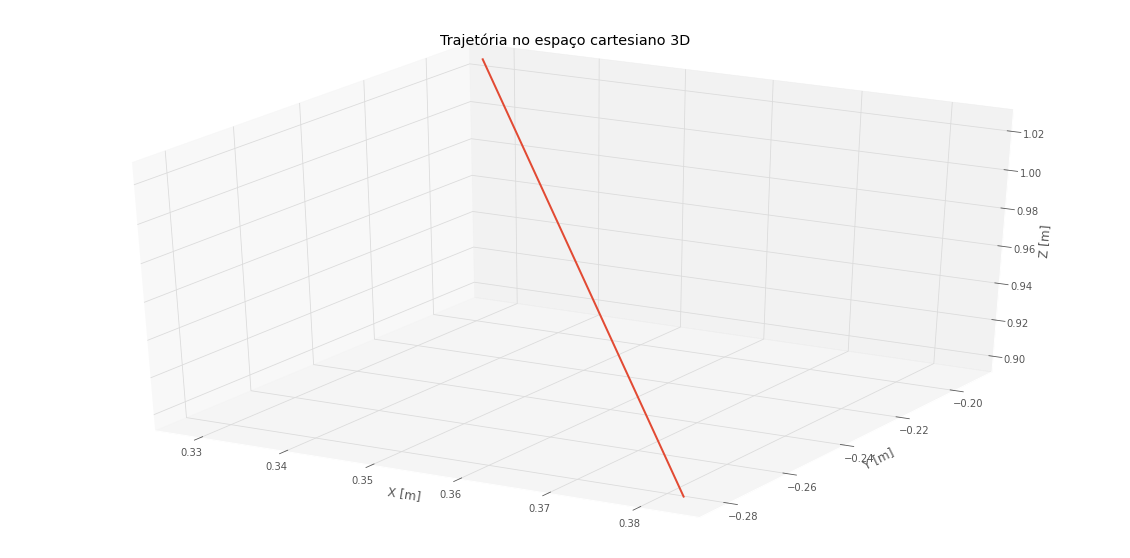

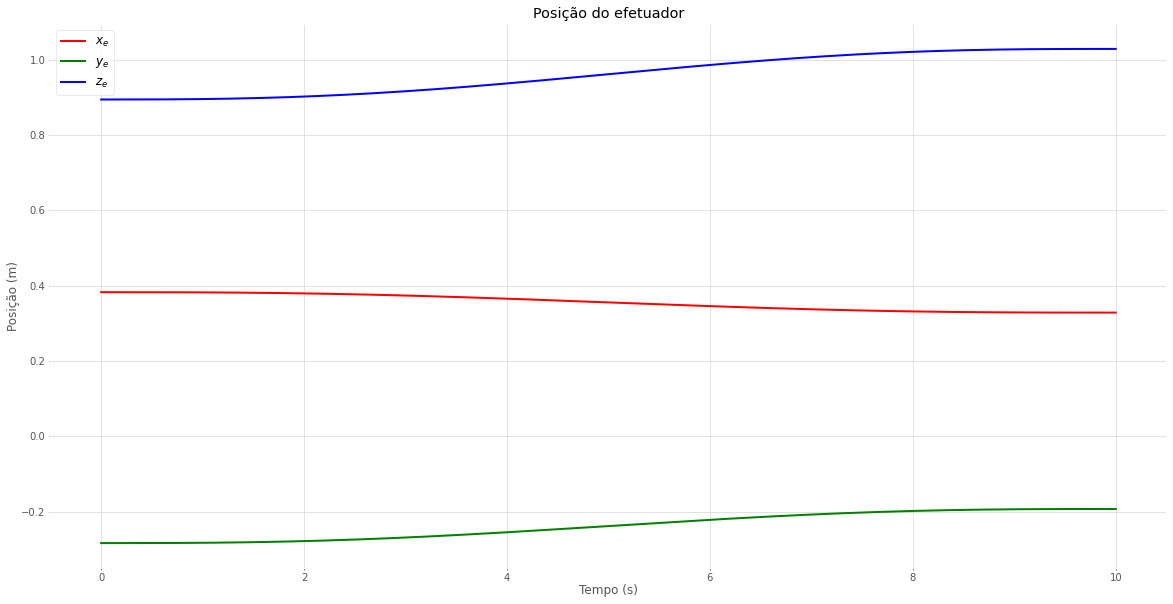

In [ ]:
robot = kinova_robot("KinovaGen3")

Td = 10.0
dt = 0.01
theta_s = np.array([1,1,1,-1,1,1,1])
theta_g = np.array([.75,.75,.75,-.75,.75,.75,.75])

q_s = theta_s
q_g = theta_g

# planejador de trajetoria no espaco cartesiano:
x_t, dx_t = calcular_trajetoria_cartesiano(robot, q_s, q_g, Td, dt)


## Verificar pontos iniciais e finais
H_s = pose_efetuador(robot, q_s)
x_s = H_s.A[0:3, 3]
print('xs = ', x_s)

H_g = pose_efetuador(robot, q_g)
x_g = H_g.A[0:3, 3]
print('xg = ', x_g)

# plotar trajetoria do planejador:
plotar_trajetoria_cartesiano(x_t, Td, dt)

# trajetoria planejada parece coincidir com a reta esperada 
#   nos pontos inicial e final

### 5.2 Conversão de trajetória no espaço cartesiano para espaço das juntas

**Método 1:** uma das formas de converter uma trajetória no espaço cartesiano para o espaço das juntas é aplicar a cinemática inversa para todos os pontos da trajetória $\mathbf{x}(t)$. Entretanto, para o manipulador redundante, para uma dada posição do efetuador, existem múltiplas configurações possíveis (soluções válidas da cinemática inversa). Portanto, é preciso aplicar um método numérico iterativo que retorna, para um ponto da trajetória, a solução de configuração *mais próxima* da configuração associada ao ponto anterior da trajetória. Dessa forma, a continuidade do movimento das juntas é preservada.

**Método 2:** Uma outra forma de fazer isso é utilizar a pseudo-inversa do Jacobiano. Entretanto, esse método não é adequado quando a trajetória passa próximo de um ponto de singularidade. Próximo da singulariade, o valor da pseudo-inversa do Jacobinado é muito alto, o que resultaria em uma velocidade de juntas também muito alta. 

Nessa tarefa, você irá aplicar o **método 2** para converter a trajetória no espaço cartesiano para o espaço das juntas.

O número de condicionamento de um função (condition number) mede quanto o valor de saída é alterado por uma pequena variação na entrada. Aplicado a matriz, quando o determinante da matriz é zero, o número de condicionamento é infinito.

No método 2 para controle de trajetória de robôs manipuladores, deve-se evitar trajetórias que passam próximo de configurações singulares, onde o determinante da matriz Jacobiano é zero. Ao invés de verificra ao longo da trajetória o determinante do Jacobinao, iremos verificar o número de condicionamento que pode ser utilizado para matrizes não quadradas:

`c = np.linalg.cond(matriz)`

Se o número de condicionamento do Jacobiano de velocidade linear $cond(J_v)$ for menor que um limiar, ou seja, $cond(J_v) < J_{max}$, então o ponto está suficientemente longe da singularidade, e podemos calcular a pseudo-inversa $J_v^{-1}$. 

Então, para construir a trajetória no espaço das juntas:

$$ \mathbf{q}(0) = \mathbf{q_s}$$

Para $t = 0 \ldots (T_d-dt)$:

$$c_J(t) = cond(J_v(\mathbf{q}(t)))$$
$$\mathbf{\dot q}(t) = ({^0J_v}(\mathbf{q}(t)))^{-1} [{^0R_B} {^B\mathbf{\dot x}}(t)] $$
$$\delta \mathbf{q} = ({^0J_v}(\mathbf{q}(t)))^{-1} [{^0R_B}[\mathbf{x}(t+dt) - \mathbf{x}(t)]]$$
$$\mathbf{q}(t+dt) = \mathbf{q}(t) + \delta \mathbf{q}$$

Implementar a seguinte função de conversão que retorna uma matriz com as configurações do robô para cada instante de tempo. Não se preocupe, se a configuração final da trajetória não for a mesma que $q_g$. O importante é que a posição final do efetuador seja igual a posição final desejada.

In [ ]:
def trajetoria_cartesiano_para_juntas(robot,q_s, q_g, x_t, dx_t, Td, dt, J_min):
  t = np.arange(0,Td+dt,dt)
  n_juntas = len(robot.revolutejoints)

  # iniciar saidas
  q_t  = np.empty( (len(t), n_juntas) )
  dq_t = np.empty( (len(t), n_juntas) )
  cJ_t = np.empty( (len(t), 1) )

  ## usando jacob0 nao precisa multiplicar por R_B0
  # H_B0 = np.array(SE3.Rz(0)*SE3(0,0,0)*SE3(0,0,0)*SE3.Rx(pi))
  # R_B0 = H_B0[0:3, 0:3]

  # inicializar laco
  q_t[0,:]  = q_s
  q = q_s
  for tk in range(len(t)-1):
    
    J = robot.jacob0(q_t[tk,:])
    cJ = np.linalg.cond(J)

    if cJ < J_min:
      J_inv = np.linalg.pinv(J[0:3, :]) #pseudo-inversa de Jv
      
      dq = np.dot( J_inv, (x_t[tk+1,:] - x_t[tk,:]) ) # variacao de q
      q = q + dq

      q_t[tk+1,:]  = q
      dq_t[tk,:] = dq
      cJ_t[tk] = cJ
    # ultimos valores de dq_t e cJ_t nao sao calculados
    
    else:
      print('Número de condicionamento muito alto, possível singularidade')
      return # finalizar a funcao


  return q_t, dq_t, cJ_t

In [ ]:
robot = kinova_robot("KinovaGen3")

Td = 10.0
dt = 0.01
theta_s = np.array([1,1,1,-1,1,1,1])
theta_g = np.array([.75,.75,.75,-.75,.75,.75,.75])

q_s = theta_s
q_g = theta_g


# planejador de trajetoria no espaco cartesiano:
x_t, dx_t = calcular_trajetoria_cartesiano(robot, q_s, q_g, Td, dt)


J_min = 100
# espaco de configuracao da saida do sistema controlado
q_t, dq_t, cJ_t = trajetoria_cartesiano_para_juntas(robot,q_s, q_g, x_t, dx_t, Td, dt, J_min)



print('máximo valor do condicionamento = ', np.max( np.abs(cJ_t) ))
# máximo valor do condicionamento =  23.116292347506246

print('q_s = ', q_t[0,:])
print('q_g = ', q_t[-1,:])
# q_s =  [       1        1        1       -1        1        1        1]
# q_g =  [   0.861   0.7118   0.9904  -0.7053   0.9198   0.7519        1]

# q_g difere do fornecido, 
#   mas plots futuros mostram que a posicao final do efetuador eh igual a desejada


# Converter através da função 'pose_efetuador' a trajetoria no espaço das juntas para trajetória do efetuador no espaço cartesiano
H = pose_efetuador(robot, q_t)
H = np.array(H.A)

# Trajetória no espaço cartesiano usando a função 'plotar_trajetoria_cartesiano'
x_e = H[:,0:3,3] #(3,1)

print('máxima diferença de trajetórias = ', np.max( np.abs(x_e - x_t) ))
# máxima diferença de trajetórias =  4.606030044929099e-05

# valor relativamente baixo,
#   a trajetoria planejada e a saida do sistema controlado parecem ser bem proximas

máximo valor do condicionamento =  23.116292347506246
q_s =  [       1        1        1       -1        1        1        1]
q_g =  [   0.861   0.7118   0.9904  -0.7053   0.9198   0.7519        1]
máxima diferença de trajetórias =  4.606030044929099e-05


###5.3 Plotar Resultado 

Para verificar se a trajetória controlada está correta, podemos converter a trajetória no espaço das juntas que foi resultado da funcão `trajetoria_cartesiano_para_juntas` em trajetória no espaço cartesiano, e plotar essa trajetória.

In [ ]:
def plotar_trajetoria_cartesiano_resultado(robot, q_t, dt, Td):
  # Converter através da função 'pose_efetuador' a trajetoria no espaço das juntas para trajetória do efetuador no espaço cartesiano
  H = pose_efetuador(robot, q_t)
  H = np.array(H.A)

  # Plotar a trajetória no espaço cartesiano usando a função 'plotar_trajetoria_cartesiano'
  x_e = H[:,0:3,3] #(3,1)
  plotar_trajetoria_cartesiano(x_e, Td, dt)

xs =  [  0.3828  -0.2829   0.8941]
xg =  [  0.3286  -0.1924    1.028]


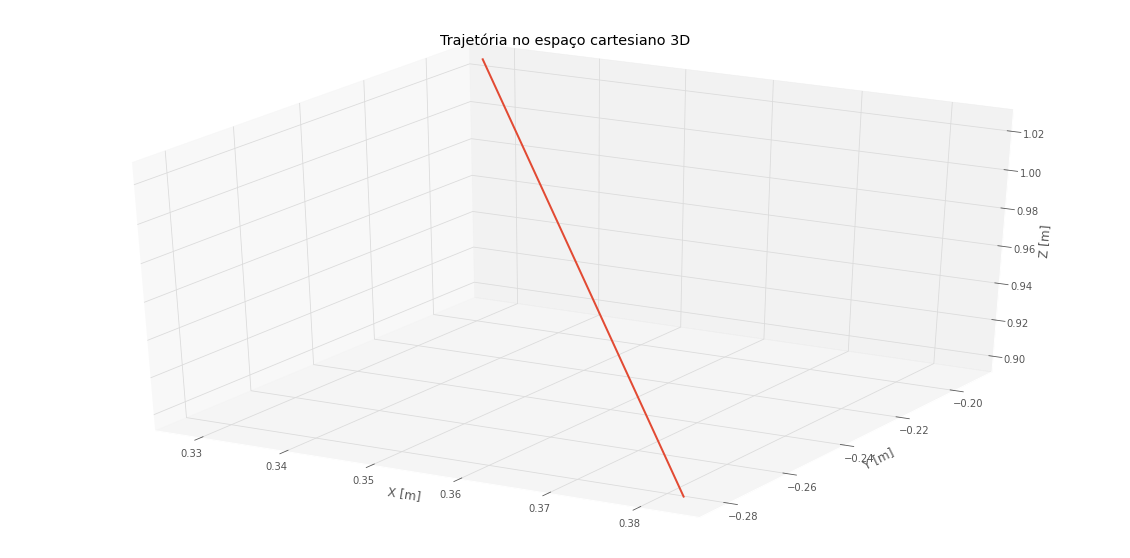

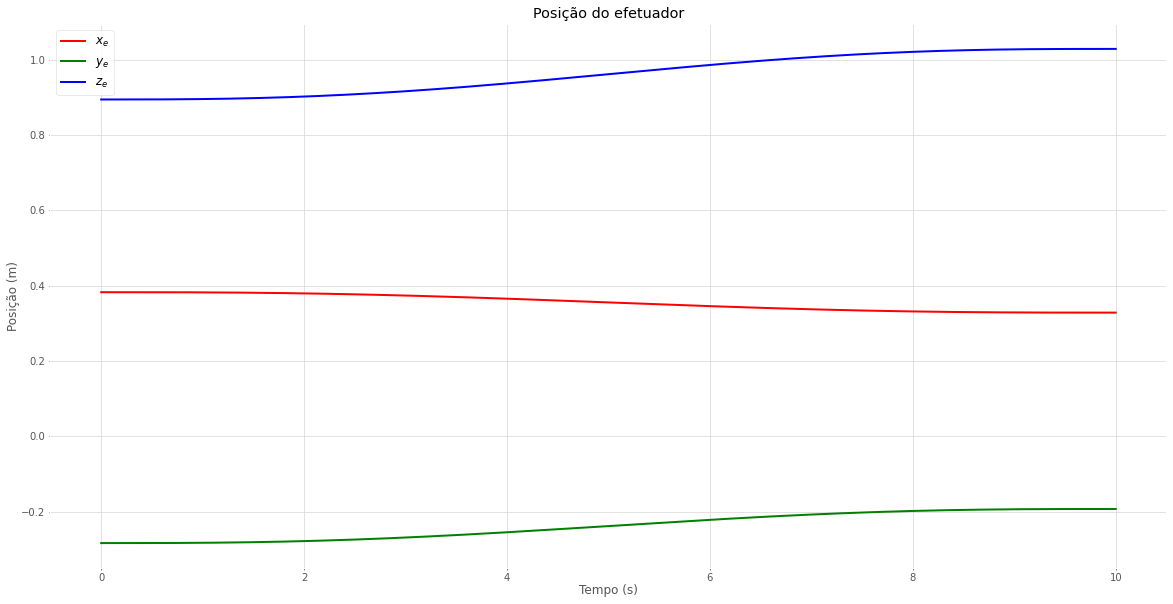

In [ ]:
robot = kinova_robot("KinovaGen3")

Td = 10.0
dt = 0.01
theta_s = np.array([1,1,1,-1,1,1,1])
theta_g = np.array([.75,.75,.75,-.75,.75,.75,.75])

q_s = theta_s
q_g = theta_g


# planejador de trajetoria no espaco cartesiano:
x_t, dx_t = calcular_trajetoria_cartesiano(robot, q_s, q_g, Td, dt)

J_min = 100
# espaco de configuracao da saida do sistema controlado
q_t, dq_t, cJ_t = trajetoria_cartesiano_para_juntas(robot,q_s, q_g, x_t, dx_t, Td, dt, J_min)


## Verificar pontos iniciais e finais
H_s = pose_efetuador(robot, q_s)
x_s = H_s.A[0:3, 3]
print('xs = ', x_s)

H_g = pose_efetuador(robot, q_g)
x_g = H_g.A[0:3, 3]
print('xg = ', x_g)


# trajetoria do sistema controlado
plotar_trajetoria_cartesiano_resultado(robot, q_t, dt, Td)

# o plot eh bastante similar a trajetoria planejada,
#   o controle parece funcionar


### 5.4 Teste as funções implementadas

Escolha uma configuração inicial $\mathbf{q_s}$ e final para o robô $\mathbf{q_g}$ de forma que não exista pontos de singularidade ao longo da trajetória reta entre as configuracões. Escolha também um valor de $T_d$ e $dt$.

Teste as funções implementadas em 5.1 e 5.2 para os valores escolhidos, e plote um gráfico com a trajetória 3D do efetuador no espaço cartesiano, e um gráfico com a trajetória no espaço das juntas do manipulador. 

In [ ]:
def plotar_trajetoria_juntas(theta_t, Td, dt):
  # Coloque seu codigo aqui
  t = np.arange(0,Td+dt,dt)

  legenda = ['Junta 1','Junta 2','Junta 3','Junta 4','Junta 5','Junta 6','Junta 7']

  # plotar resultados
  plt.figure(figsize=(20,10))
  plt.plot(t,theta_t)
  plt.title('Posição da junta')
  plt.ylabel('Posição [Ângulo] (rad)')
  plt.xlabel('Tempo (s)')
  plt.legend(legenda)
  plt.grid(True)

xs =  [  0.3828  -0.2829   0.8941]
xg =  [  0.3286  -0.1924    1.028]
máximo valor do condicionamento =  100.0
máxima diferença de trajetórias =  4.606030044929099e-05


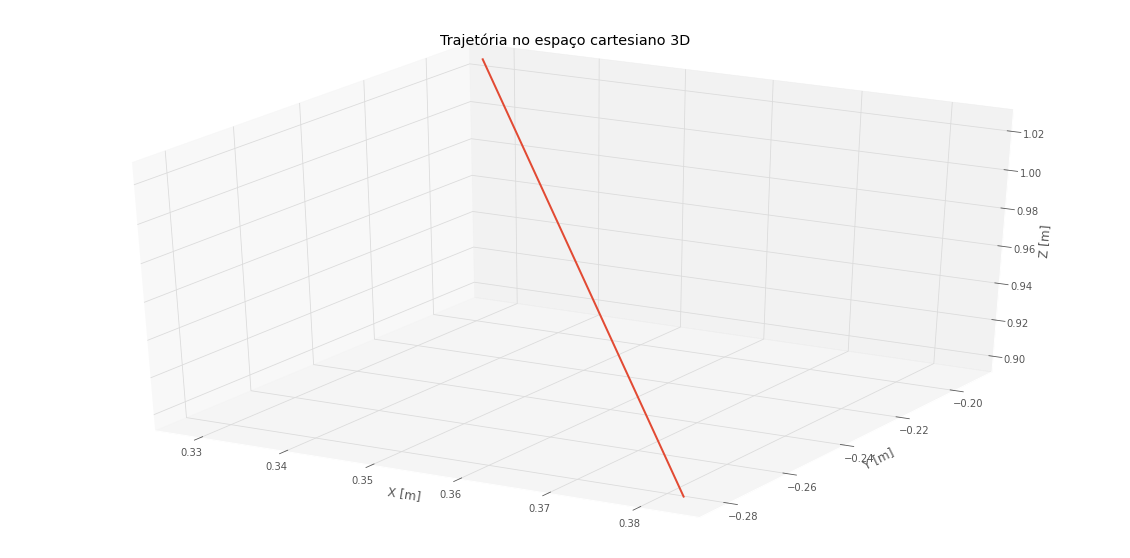

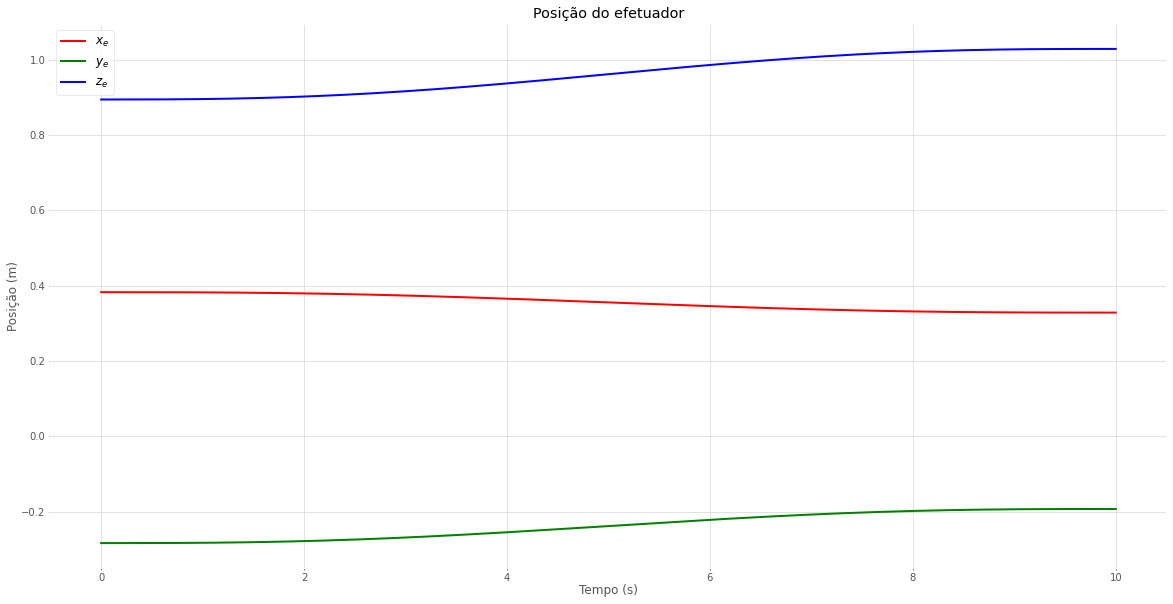

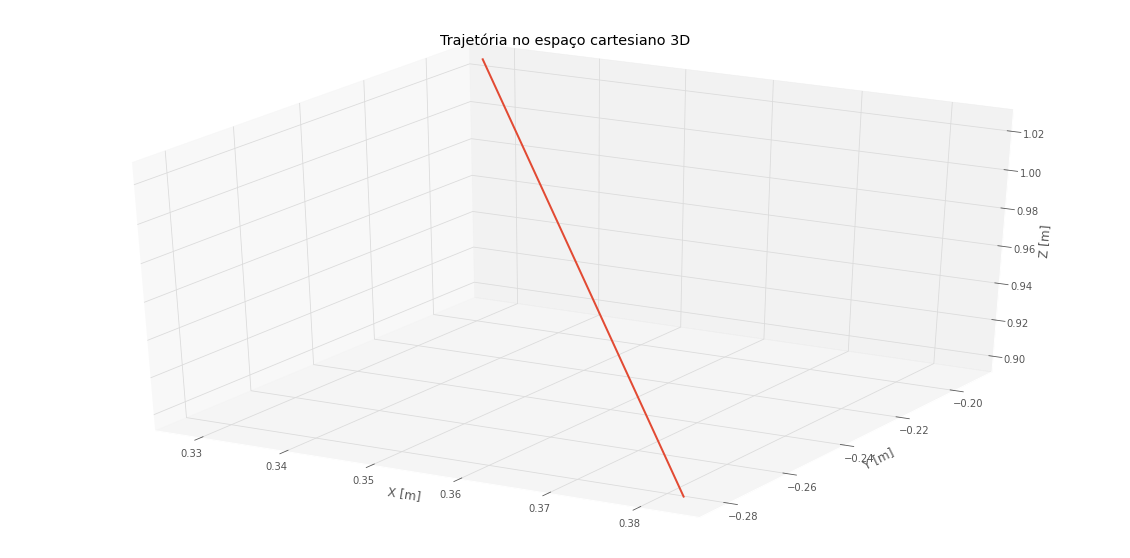

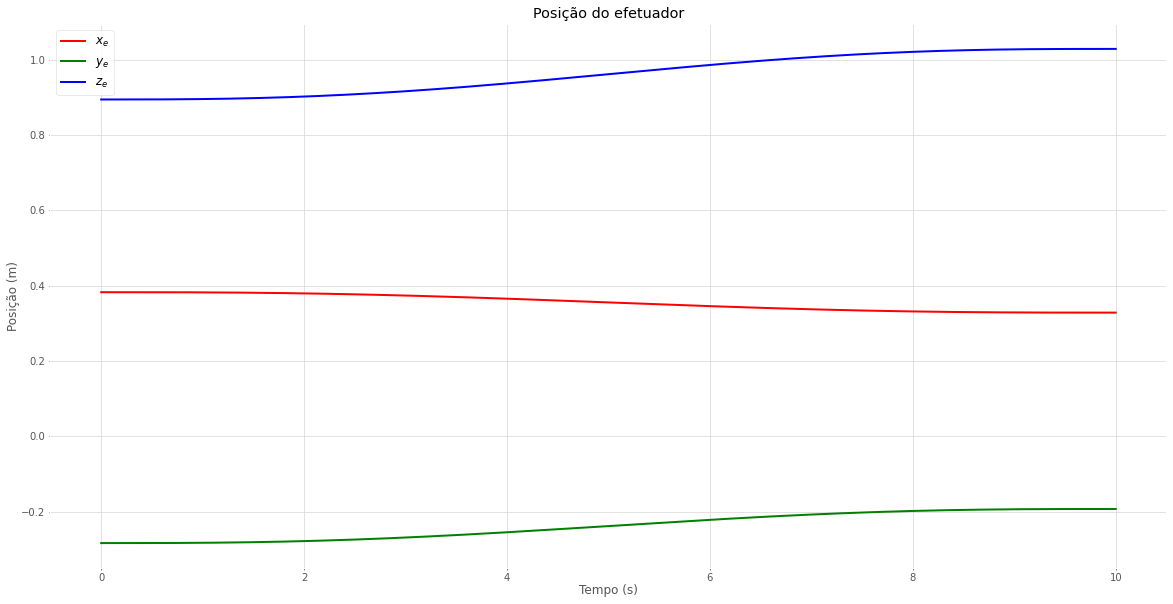

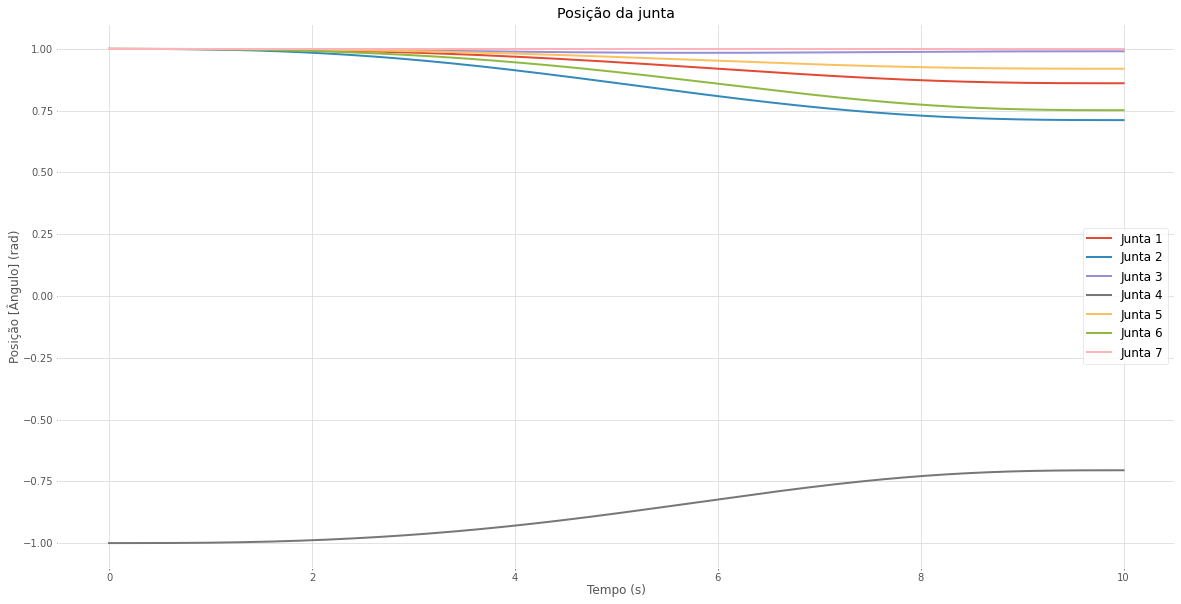

In [ ]:
robot = kinova_robot("KinovaGen3")

Td = 10.0
dt = 0.01
theta_s = np.array([1,1,1,-1,1,1,1])
theta_g = np.array([.75,.75,.75,-.75,.75,.75,.75])

q_s = theta_s
q_g = theta_g

### PLANEJADOR ###
# planejador de trajetoria no espaco cartesiano:
x_t, dx_t = calcular_trajetoria_cartesiano(robot, q_s, q_g, Td, dt)
# plot do planejamento de trajetoria:
plotar_trajetoria_cartesiano(x_t, Td, dt)

# Verificar pontos iniciais e finais
H_s = pose_efetuador(robot, q_s)
x_s = H_s.A[0:3, 3]
print('xs = ', x_s)

H_g = pose_efetuador(robot, q_g)
x_g = H_g.A[0:3, 3]
print('xg = ', x_g)


### SISTEMA CONTROLADO ###
J_min = 100
# espaco de configuracao da saida do sistema controlado
q_t, dq_t, cJ_t = trajetoria_cartesiano_para_juntas(robot,q_s, q_g, x_t, dx_t, Td, dt, J_min)

# plot da saida do sistema controlado no espaco cartesiano:
plotar_trajetoria_cartesiano_resultado(robot, q_t, dt, Td)
# plot da saida do sistema controlado no espaco das juntas:
plotar_trajetoria_juntas(q_t, Td, dt)
# o espaco das juntas parece ter trajetoria continua,
#   assim o controle eh fisicamente possivel


### VERIFICAOES ###
print('máximo valor do condicionamento = ', np.max( np.abs(cJ_t) ))
# máximo valor do condicionamento =  23.116292347506246

# Converter através da função 'pose_efetuador' a trajetoria no espaço das juntas para trajetória do efetuador no espaço cartesiano
H = pose_efetuador(robot, q_t)
H = np.array(H.A)

# Trajetória no espaço cartesiano usando a função 'plotar_trajetoria_cartesiano'
x_e = H[:,0:3,3] #(3,1)

print('máxima diferença de trajetórias = ', np.max( np.abs(x_e - x_t) ))
# máxima diferença de trajetórias =  4.606030044929099e-05

# valor relativamente baixo,
#   a trajetoria planejada e a saida do sistema controlado parecem ser bem proximas
